#Scraping Retrosheet database for Batter-Pitcher Matchups

In [25]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import json
import sys
from scipy import stats

%matplotlib inline

The files below come from the Lahman database. We use them to compile a list of batters who appeared between 2004 and 2014.

In [26]:
master = pd.read_csv('data/lahman/Master.csv')
all_batting = pd.read_csv('data/lahman/Batting.csv')

In [27]:
lah_to_retro = dict(zip(master['playerID'], master['retroID'])) #key=lahmanID, value=retroID
retro_to_lah = dict(zip(master['retroID'], master['playerID'])) #reverse of above

retro_ids = [lah_to_retro[name] for name in all_batting['playerID']] 
all_batting['retroID'] = retro_ids

is_modern_batter = (all_batting['yearID'] >= 2004)
batter_ids = np.unique(all_batting['retroID'][is_modern_batter]) #array of unique batter IDs

modern_mask = np.array([name in batter_ids for name in all_batting['retroID']])
batting = all_batting[modern_mask] #data frame with batting stats of "modern" batters

How many unique batters appeared between 2004 and 2014?

In [28]:
len(batter_ids)

3561

For these batters, we can look at the distribution of how many at bats they had. We use a Kernel Density Estimator (KDE) to smooth out the distribution.

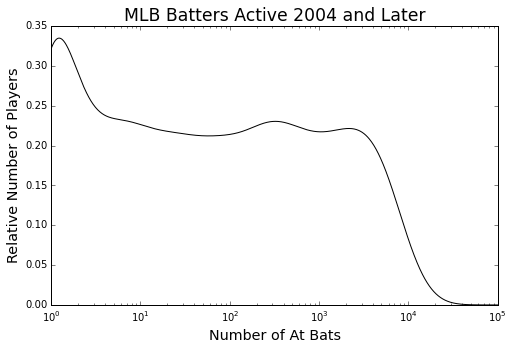

In [29]:
ABs = batting.groupby('retroID')['AB'].sum()
Hs = batting.groupby('retroID')['H'].sum()
kde_ABs = stats.gaussian_kde(np.log10(ABs+1)) #make a KDE of density of log AB (+1 because many players with zero AB)

fig, axis = plt.subplots(figsize=(8,5))
x = np.linspace(0, 5, 1000)
axis.plot(10**x, kde_ABs(x), 'k-')
axis.set_xscale('log')
axis.set_xlabel('Number of At Bats', fontsize='x-large'), axis.set_ylabel('Relative Number of Players', fontsize='x-large')
axis.set_title('MLB Batters Active 2004 and Later', fontsize='xx-large')

##Scrape the matchup webpages from Retrosheet

In [202]:
def retro_url(retroID):
    return 'http://www.retrosheet.org/boxesetc/%s/MU0_%s.htm'%(retroID[0].upper(), retroID)

For ~3000 batters, the process below takes around 10-15 minutes

In [206]:
def scrape_pages(batter_ids, cache=True):
    """
    Given a list of batter_ids, find all the retrosheet pitcher matchup pages for each batter.
    Copy the text from each page, and store in dictionary keyed by batterID. Some batters may not be found,
    so this also records those that are/aren't found.
    
    This process takes a long time, so it caches the results to disk throughout. Prints out the progress.
        
    input
    --------
    batter_ids: iterable list or array of retrosheet player IDs
    
    output
    --------
    batter_pages: dictionary of text for all matchup pages found, keyed by batterID
    found: list of batterIDs for which matchup pages were found
    not_found: list of batterIDs for which no matchup pages could be found
    """
    
    batter_pages = {} #key: retroID, value: text of matchup page
    found = []
    not_found = []
    
    for i, batter in enumerate(batter_ids):
        time.sleep(.2)
        url = retro_url(batter)
        if (i%100==0):
            print('%d of %d'%(i, len(batter_ids)))
            if cache:
                f = open('data/batter_pages.json', 'w') #cache the results to disk as we go, in case this fails
                json.dump(batter_pages, f)
                f.close()
        req=requests.get(url)
        if req.status_code==200:
            batter_pages[batter] = req.text
            found.append(batter)
        else: #Some batters with very few at bats will not have pages.
            not_found.append(batter)
    return batter_pages, found, not_found

In [207]:
batter_pages, found, not_found = scrape_pages(batter_ids)

0 of 3561
100 of 3561
200 of 3561
300 of 3561
400 of 3561
500 of 3561
600 of 3561
700 of 3561
800 of 3561
900 of 3561
1000 of 3561
1100 of 3561
1200 of 3561
1300 of 3561
1400 of 3561
1500 of 3561
1600 of 3561
1700 of 3561
1800 of 3561
1900 of 3561
2000 of 3561
2100 of 3561
2200 of 3561
2300 of 3561
2400 of 3561
2500 of 3561
2600 of 3561
2700 of 3561
2800 of 3561
2900 of 3561
3000 of 3561
3100 of 3561
3200 of 3561
3300 of 3561
3400 of 3561
3500 of 3561


In [8]:
#Store the results to disk
f = open('data/batter_pages.json', 'w')
json.dump(batter_pages, f)
f.close()

f = open('data/found.json', 'w')
json.dump(found, f)
f.close()

f = open('data/not_found.json', 'w')
json.dump(not_found, f)
f.close()

In [30]:
#Restore the results from disk
with open("data/batter_pages.json", "r") as f:
    batter_pages = json.load(f)
with open("data/found.json", 'r') as f:
    found = json.load(f)
with open("data/not_found.json", 'r') as f:
    not_found = json.load(f)

How many batters did we find matchup pages for? (All 3 values should be equal)

In [31]:
print len(batter_pages), len(found), len(batter_ids) - len(not_found)

1864 1864 1864


Why did we miss so many players? Turns out that players with $N<100$ ABs may often not have a matchup page.

In [32]:
AB_missed = np.array([ABs[name] for name in not_found])
AB_found = np.array([ABs[name] for name in found])

In [33]:
kde_missed = stats.gaussian_kde(np.log10(AB_missed + 1))
kde_found = stats.gaussian_kde(np.log10(AB_found+1))

(<matplotlib.legend.Legend at 0x13278e750>,
 <matplotlib.text.Text at 0x14fca3810>)

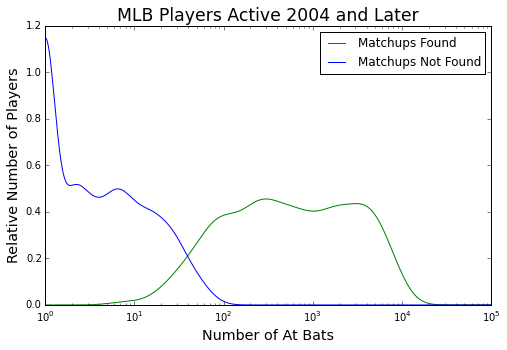

In [34]:
fig, axis = plt.subplots(figsize=(8,5))
x = np.linspace(0, 5, 1000)
# axis.hist(AB_missed+1, histtype='step', normed=True,  label='Matchups Not Found', bins=np.logspace(0, 2, 12))
# axis.hist(AB_found+1, histtype='step', normed=True, label='Matchups Found', bins=np.logspace(0.5, 4.5, 20))
plt.plot(10**x, kde_found(x), 'g-', label='Matchups Found')
plt.plot(10**x, kde_missed(x), 'b-', label='Matchups Not Found')
axis.set_xscale("log")
axis.set_xlabel(r'Number of At Bats', fontsize='x-large'), axis.set_ylabel('Relative Number of Players', fontsize='x-large')
axis.legend(loc=0), axis.set_title('MLB Players Active 2004 and Later', fontsize='xx-large')

##Process the page text into a matchup dataframe

In [17]:
def stats_parse(line):
    """
    Takes a line, which is a length-15 list of statistics for each matchup:
    R/L, AB, H, 2B, 3B, HR, BB, IBB, SO, HBP, SH, SF, AVG, OBP, SLG
    
    Returns a list with quantities: [AB, PA, H, TB, W, SO, SAC, RL]
    AB: At Bats
    PA: Plate Appearances (AB + W)
    H: Hits
    TB: Total Bases (H + 2*2B + 3*3B + 4*HR)
    W: Walks (BB + IBB + HBP)
    SO: Strike Outs
    SAC: Sacrifices (SH + SF)
    RL: Righty/Lefty pitcher
    """
    RL = line[0] #R/L handed pitcher
    AB = int(line[1]) #At Bats
    H = int(line[2]) #Hits
    TB = int(line[2]) + 2*int(line[3]) + 3*int(line[4]) + 4*int(line[5]) #Total Bases
    W = int(line[6]) + int(line[7]) + int(line[9]) #Walks (BB + IBB + HBP)
    PA = AB + W #Plate Appearances
    SO = int(line[8]) #Strikeouts 
    SAC = int(line[10]) + int(line[11]) #Sacrifices
    return [AB, PA, H, TB, W, SO, SAC, RL]

In [18]:
def parse_pages(pages, batterIDs=None):
    """
    Takes a dictionary pages with retroIDs of batters as keys,
    and the text of that batter's Retrosheet matchup sheet as values.
    Takes an optional array of retroIDs for batters.
    
    Returns a list of one dictionary for each batter-pitcher matchup, with fields:
    pID: pitcher ID
    bID: batter ID
    AB: number of At Bats
    PA: number of Plate Appearances
    H: number of Hits
    SLUG: slugging value (H + 2*2B + 3*3B + 4*HR)
    W: number of Walks
    SO: number of Strike Outs
    SAC: number of Sac Flies and Sac Bunts
    """
    matchup_list = []
    
    if batterIDs is None:
        batterIDs = pages.keys()
    
    for batterID in batterIDs:
        text = pages[batterID]
        if text=='':
            continue
        soup = BeautifulSoup(pages[batterID], 'html.parser')
        data = soup.find_all('pre')[2]
        for i in np.arange(1, len(data.contents), 2):
            row = {}
            pitcherID = data.contents[i].get('href').split('/')[-1].split('.')[0].lstrip('P') #8-char retroID
            assert(len(pitcherID)==8)
            stats = data.contents[i+1].split('\n')[0].split() #list of stats values
            assert(len(stats) == 15)
            stats = stats_parse(stats)
            fields = ['AB', 'PA', 'H', 'TB', 'W', 'SO', 'SAC', 'RL']
            matchup = dict(zip(fields, stats))
            matchup['pID'] = pitcherID
            matchup['bID'] = batterID
            matchup['matchID'] = '%s_%s'%(batterID, pitcherID)

            matchup_list.append(matchup)
    return matchup_list

##Process all the text from the matchup pages

In [19]:
matchup_list = parse_pages(batter_pages)

How many total matchups found?

In [20]:
len(matchup_list)

248420

In [21]:
f = open('data/matchups.json', 'w')
json.dump(matchup_list, f)
f.close()

In [22]:
matchup_df = pd.read_json("data/matchups_2004.json")

In [23]:
matchup_df.head(30)

,AB,H,PA,RL,SAC,SO,TB,W,bID,pID
0,5,1,5,R,0,2,1,0,torrc001,medlk001
1,3,0,3,L,1,2,0,0,kinnm002,leita001
2,4,1,4,R,0,2,1,0,valee002,ayall001
3,7,0,7,R,0,4,0,0,valee002,beckj002
4,3,2,6,R,0,0,2,3,valee002,bumpn001
5,4,0,4,R,0,3,0,0,valee002,burna001
6,4,1,4,R,0,1,5,0,valee002,byrdp001
7,6,0,6,R,0,3,0,0,valee002,clemr001
8,4,1,5,R,0,1,1,1,valee002,cordc001
9,3,2,5,R,0,0,4,2,valee002,daigc001


##Let's do some exploratory data analysis (EDA) on the matchups

In [24]:
batter_sums = matchup_df.groupby('bID').sum() #by-batter totals for H, AB, etc.
batter_matchups = matchup_df.groupby('bID')['AB'].count() #Number of pitchers seen by each player

In [9]:
kde_times_seen = stats.gaussian_kde(matchup_df['PA'])

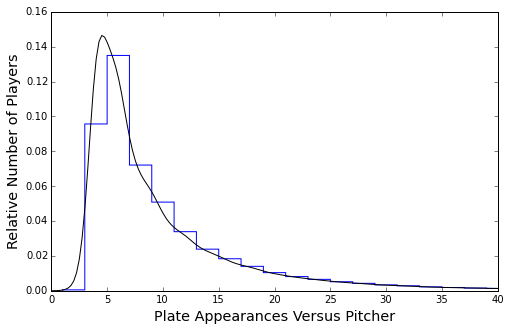

In [35]:
fig, axis = plt.subplots(figsize=(8,5))
plt.hist(matchup_df['PA'], normed=True, bins=80, histtype='step')
x = np.linspace(0, 50, 200)
axis.plot(x, kde_times_seen(x), 'k-')
axis.set_xlim([0, 40])
axis.set_xlabel('Plate Appearances Versus Pitcher', fontsize='x-large')
axis.set_ylabel('Relative Number of Players', fontsize='x-large')

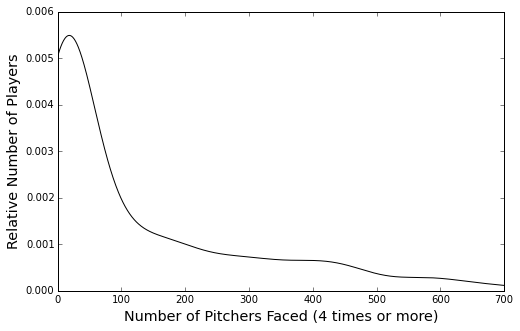

In [11]:
kde_matchups = stats.gaussian_kde(batter_matchups)
fig, axis = plt.subplots(figsize=(8,5))
x = np.linspace(0, 700, 1000)
axis.plot(x, kde_matchups(x), 'k-')
axis.set_xlabel('Number of Pitchers Faced (4 times or more)', fontsize='x-large')
axis.set_ylabel('Relative Number of Players', fontsize='x-large')

(<matplotlib.text.Text at 0x146cfb410>, <matplotlib.text.Text at 0x1439f3ed0>)

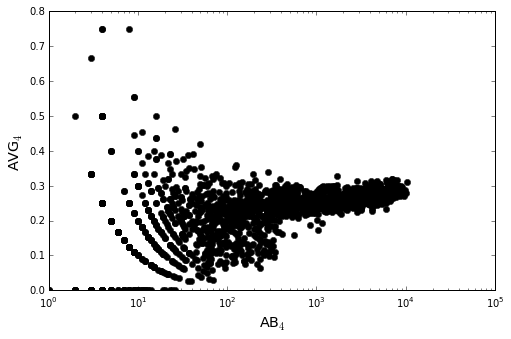

In [227]:
fig, axis = plt.subplots(figsize=(8,5))
axis.plot(batter_sums['AB'], batter_sums['H']/batter_sums['AB'], 'ko')
axis.set_xscale('log')
axis.set_ylabel(r'AVG$_4$', fontsize='x-large'), axis.set_xlabel(r'AB$_4$', fontsize='x-large')

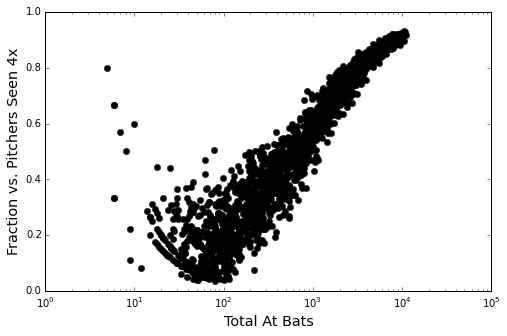

In [235]:
fig, axis = plt.subplots(figsize=(8,5))
full_ABs = np.array([ABs[name] for name in batter_sums.index])
full_Hs = np.array([Hs[name] for name in batter_sums.index])

axis.plot(full_ABs, batter_sums['AB']/full_ABs, 'ko')
# axis.plot(full_ABs, full_ABs, 'r--')
axis.set_xscale('log')
axis.set_xlabel('Total At Bats', fontsize='x-large')
axis.set_ylabel('Fraction vs. Pitchers Seen 4x', fontsize='x-large')

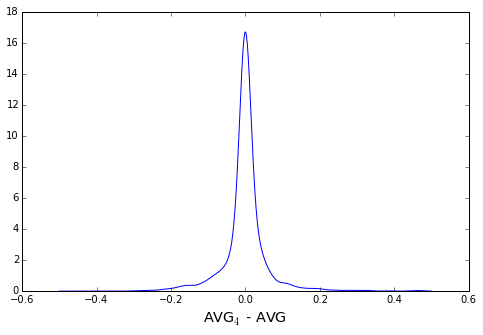

In [248]:
fig, axis = plt.subplots(figsize=(8,5))
diff_kde = stats.gaussian_kde(diff_AVG)
x = np.linspace(-.5, .5, 1000)
axis.plot(x, diff_kde(x))
axis.set_xlabel(r'AVG$_4$ - AVG', fontsize='x-large')

In [247]:
print(stats.describe(diff_AVG))

DescribeResult(nobs=1864, minmax=(-0.29032258064516131, 0.5625), mean=-0.00016852009310608826, variance=0.0037276818165337343, skewness=1.3647627116170384, kurtosis=14.620110178640953)
